In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

### Implementando Convolução

Desenvolver em Python a operação de convolução Dw x Dw x C, com bias e função de ativação (ReLU e tanh), stride (inteiro positivo) e zero padding (boolean) especificados pelo usuário em tempo de execução. A máscara convolucional e o viés devem ser especificados em arquivo texto a ser lido durante a execução. Apresentar resultados com imagens RGB e em níveis de cinza, e com volumes Df x Df x N, produzidos a partir da aplicação prévia de N filtros convolucionais. Para visualização, os mapas de ativação devem ser convertidos para imagens em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.  

### Parte 1 - Operação de Convolução

Uma operação de convolução, dada pela equação abaixo, pode ser realizada a partir da aplicação de uma máscara/filtro convolucional para cada pixel da imagem.  

\begin{align}
g[n] = \sum_{\tau=-\infty}^\infty s[\tau] h[n]-\tau]
\end{align}

Na equação, g é o resultado da operação, s o sinal de entrada e h a máscara convolucional. A Figura abaixo exemplifica a operação para um pixel em uma imagem de dimensão 8x8, utilizando máscara 3x3.

![title](imgs/conv.jpg)

Para realizar a operação em Python, duas funções deverão ser implementadas: zero_pad(X) e convolution(X, kernel, stride, padding), em que X é a imagem de entrada. Na função zero_pad(X), caso o usuário deseje realizar a operação de padding, a função deverá preencher a imagem de entrada com zeros, retornando a matriz X_pad. O método numpy.pad não deverá ser utilizado para realização dessa operação.

Na função convolution(X,kernel,stride,padding), implemente a operação de convolução propriamente dita utilizando apenas funçoes básicas da biblioteca Numpy (i.e. função convolve, convolve2d, pad e outras do Numpy não serão permitidas nesse exercício). A função retornará uma matriz out_conv e deverá ser testada com imagens RGB e em níveis de cinza, considerando quatro casos principais:

1: stride = 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada pixel da imagem;

2: stride = 1 e padding False: não utilize extensão por zeros e deslize a máscara a cada pixel da imagem;

3: stride > 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

4: stride > 1 e padding False: não dicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

OBS: ao utilizar stride > 1 ou padding, poderá ser necessário tratar casos em que a operação ultrapasse a dimensão da imagem X. 

In [2]:
def zero_pad(X, filterSize):
    """
    Função para adicionar extensão por zeros na imagem de entrada.
    Parametro: X - imagem de entrada
    Parametro: filterSize - Tamanho do filtro convolucional
    Retorno: X_pad - imagem resultante da extensão por zeros. 
    """
    
    #h,w,c = X.shape
    try:
        h,w,c = X.shape
    except ValueError:
        h,w = X.shape
        c = 1
        X = X.reshape((h,w,c))
    
    X_pad = np.zeros((h+filterSize-1,w+filterSize-1,c))
    
    padding_begin=int((filterSize-1)/2)
    padding_height=int(padding_begin+h)
    padding_width=int(padding_begin+w)
    
    X_pad[padding_begin:padding_height,padding_begin:padding_width,:] = X
    return X_pad

In [3]:
def convolution(X,filters, filter_size, stride=1, padding=True):
    """
    Função para implementar a operação de convolução.
    Parametros: X - imagem de entrada
                filters - matriz com o kernel a ser utilizado pela operação
                filter_size - tamanho do filtro convolucional
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    retorno out_conv: matriz resultante da operação de convolução
    """    
    h,w,c = X.shape
    ###out_h = int((h-filter_size+1)/stride)
    ###out_w = int((w-filter_size+1)/stride)
    out_h = int(((h-filter_size)/stride)+1)
    out_w = int(((w-filter_size)/stride)+1)
    
    out_conv = np.zeros(( out_h, out_w ))
    print('\nFormato da saída da convolução: ', out_conv.shape)
    
    for rows in range(0,h-filter_size+1,stride):
        for cols in range(0,w-filter_size+1,stride):
            out_conv[int(rows/stride),int(cols/stride)] = np.sum(np.multiply(X[rows:rows+filter_size,cols:cols+filter_size,:],filters))

    #plt.imshow(out_conv, cmap='gray',vmin = 0, vmax = 255) 
    print('\tMin = ', min(out_conv.ravel()), 'Max = ', max(out_conv.ravel()))
    
    plt.imshow(out_conv) 
    plt.show()
    
    return out_conv

### Parte 2 - Camada convolucional 

Uma vez implementada a função convolution, pode-se implementar uma camada convolucional por meio da função convLayer(X,C,act_func, kernel, stride, padding). Uma camada convolucional é ilustrada conforme Figura abaixo.

Na Figura, uma imagem de entrada 32x32x3 é utilizada com 6 máscaras 5x5x3. Para cada filtro individualmente, aplica-se o bias (offset) seguido pela aplicação da função de ativação para formar seis mapas de característica (feature maps) de dimensão 28x28x6 (32 - 4 por não utilizar padding e 6 igual a quantidade de máscaras dessa camada).

![title](imgs/convlayer.png)


Baseado nisso, para implementar a camada, deve-se seguir como passos principais:

1. Inicializar a matriz fmap: essa matriz pode ser criada utilizando numpy (e.g. np.zeros) e deverá conter a dimensão de saída do feature map (e.g. 28x28x6). Para calcular essa dimensão, utilize a equação abaixo, em que C é igual ao volume do feature map:
\begin{align}
n_H = (X_H - filter_H+2*padding)/stride+1\\
n_W = (X_W - filter_W+2*padding)/stride+1\\
n_C = C
\end{align}

2. Se padding for necessário, realizar a operação implementada pela função zero_pad(X);

3. Implementar função de ativação. As funções de ativação definem o intervalo de valores que a saída do neurônio poderá ter. Nsse Notebook, duas funções de ativação devem ser implementadas (ReLU e Tanh). As funçoes, suas respectivas saídas e gráfico deverão ser similares ao exposto abaixo: 

-> Retificadora (Relu): saída 0 caso entrada seja negativa e maior que 1 caso contrário
$$ \begin{equation}
  relu = max(0,x)
\end{equation} $$
![alt text](imgs/relu.png "Title")
-> Tangente Hiperbólica: saída entre [-1,1]
$$ \begin{equation}
  tanh = \frac{2}{(1+e^{-2*z})} - 1
\end{equation} $$
![alt text](imgs/tanh.png "Title")

4. Para cada filtro, produzir um feature map a partir da aplicação da convolução, adicionando-se um bias e utilizando a função de ativação implementada na etapa 3.

5. Visualizar o feature map convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.



In [4]:
def relu(num):
    return max(0,num)

In [5]:
def tanh(num):
    try:
        ans = math.exp(-(2*num))
    except OverflowError:
        ans = float('inf')

    return (2/(1+(ans)))-1
    #return 1-(math.tanh(num))


In [6]:
def activation_func(func_type, z):
    """
    Função que implementa as funções de ativação ReLU e Tanh
    Parãmetros: func_type - uma string que contém a função de ativação desejada
                z - matriz resultante da convolução e do bias.
    Retorna: feature map
    """
    ### Seu código aqui (~2 linhas)
    if func_type == 'relu':
        ##Para cada pixel, substituir os valores menores que zero para zero, retornando matriz resultante
        #return list(map(lambda x: max(0,x), z))
        return np.reshape((list(map(relu,z.ravel()))), z.shape)
    elif func_type == 'tanh':
        ##Para cada pixel, mapear seus valores entre -1 e 1, retornando matriz resultante
        ###print('\n\nValores antes da função de ativação tanh: \tMin = ', min(z.ravel()), 'Max = ', max(z.ravel()))
        
        p = np.reshape((list(map(tanh,z.ravel()))), z.shape)
        if min(p.ravel()) == max(p.ravel()):
            print('\n\tNão foi possível efetuar a ativação pela função hiperbólica. Valor mínimo e máximo são iguais')
            return z
            
        ###print('\n\nValores depois da função de ativação tanh: \tMin = ', min(p.ravel()), 'Max = ', max(p.ravel()))
        return p

In [7]:
def visualize_fmap(X):
    """
    Função que convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], 
    com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.
    """
    h,w,c = X.shape
    
    ###Exibição ABS com preto = 0
    
    #Calcula o módulo da matriz
    ABS = abs(X)
    
    #Subtrai o menor valor em todos os elementos da matriz
    ABS = np.subtract(ABS, min(ABS.ravel()))
    
    #Mapeia a matriz para [0,255] 
    map_value_abs = (255/max(ABS.ravel()))
    ABS = np.multiply(ABS, map_value_abs)
    
    print('\n\n\t\tFeature Map em valor ABS com preto = zero : ')
    for layer in range(0,c):
        plt.imshow(ABS[:,:,layer], cmap='gray') 
        plt.show() 
    
    ###Exibição MIN = preto
    MIN = X
    
    #Subtrai o menor valor em todos os elementos da matriz
    MIN = np.subtract(MIN, min(MIN.ravel()))
    
    #Mapeia a matriz para [0,255] 
    map_value_min = (255/max(MIN.ravel()))
    MIN = np.multiply(MIN, map_value_min)
    
    print('\n\n\t\tFeature Map com mínimo = preto : ')
    
    for layer in range(0,c):
        plt.imshow(MIN[:,:,layer], cmap='gray') 
        plt.show() 
    
    #for layer in range(0,c):
        #plt.imshow(X[:,:,layer], cmap='gray',vmin = 0, vmax = 255) 
        #plt.show()  
    

In [8]:
def convLayer(imageFile,C,act_func, filters, stride, padding, filter_size):
    """
    Implementa a camada convolucional utilizando bias e função de ativação.
    Parametros: imageFile - matriz de entrada
                C - quantidade de canais do feature map
                filters - filtros utilizados na camada
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    Retorno: fmap - feature map de dimensão (n_W,n_H, C)
    """
    
    ##Inicia matriz fmap considerando o padding e o stride para determinar o tamanho final e quantidades de Canais
    h,w,c = imageFile.shape

    fmap = np.zeros((int(((h-filter_size)/stride)+1), int(((w-filter_size)/stride)+1), C))
    ####fmap = np.zeros(( int((h-filter_size+1)/stride), int((w-filter_size+1)/stride), C))
    
    current_filter = np.zeros((filter_size, filter_size, c)) #Filtro com 3 dimensões (c = número de camadas)
    current_bias = 0
    ptr_filter = filter_size
    
    ##Para cada filtro, chamar a função de convolução       
    rows, cols = filters.shape
    number_filters = int(rows/filter_size)
    
    for count in range(0, C):
        current_bias = filters[ptr_filter-1,0]  #Armazena o bias do filtro específico contido no arquivo csv
        for layer in range(0,c):
            current_filter[:,:,layer] = filters[ptr_filter-filter_size:ptr_filter,1:]  #Preenche a matriz de filtro atual
            ptr_filter += filter_size
        print('\nFiltro Corrente: \n', current_filter, '\n')
        
        ##Adicionar o bias no resultado da convolução
        tmp_map = convolution(imageFile,current_filter, filter_size, stride, padding)
        tmp_map = np.add(tmp_map,current_bias)
        
        ##Chamar a função de ativação na matriz resultante
        tmp_map = activation_func(act_func, tmp_map)
        #print(min(tmp_map.ravel()), max(tmp_map.ravel())) ##Menor e maior valor depois da função de ativação
        
        ##Adicionar cada feature map da convolução anterior na matriz fmap
        fmap[:,:,count] = tmp_map
        
        #ptr_filter += filter_size
        
    #print('\n[Resultado] Feature Map: ', fmap)
    
    return fmap

### Parte 4 - Main

Para finalizar, utilize a função main para leitura dos filtros e bias obtidos a partir de um arquivo csv. O arquivo poderá ser lido a partir de métodos do numpy (e.g. genfromtxt e loadfromtxt). Uma vez que stride e padding deverão ser especificados pelo usuário, a função input do Numpy poderá ser utilizada para obter os valores. Por fim, a imagem de entrada poderá ser obtida por meio de métodos da biblioteca PIL (i.e. Image), OpenCV, entre outros.

In [18]:
def main():
    ##Carregar os filtros do arquivos txt
    file_name = 'nnfilter5.csv'
    convFilters = np.loadtxt(file_name, delimiter=',', dtype=float, skiprows=1)
    print('Lista de filtros: \n',convFilters, '\n')
    
    stride = int(input("Entre com um valor inteiro positivo para o stride "))
    padding = input("Sua operaçao será feita com padding? True or False  ") 
    
    ##Tamanho do Filtro (Dw x Dw x C)
    filter_size = 5
    
    imageFile = np.asarray(Image.open('imgs/albert-einstein.jpg'))
    print('\nFomato da Imagem Original',imageFile.shape)

    if padding=='True':
        padding = True
        imageFile = zero_pad(imageFile, filter_size)
        print('Padding adicionado', imageFile.shape)
        
    #plt.imshow(imageFile) 
    
    fmap = convLayer(imageFile, 2, 'relu', convFilters, stride, padding, filter_size)
    
    print('\n\nFormato do fmap: \n', fmap.shape)
    
    visualize_fmap(fmap)   
    

Lista de filtros: 
 [[ 5.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
   4.000000e+00]
 [ 5.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
   4.000000e+00]
 [ 5.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
   4.000000e+00]
 [ 5.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
   4.000000e+00]
 [ 5.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00
   4.000000e+00]
 [ 4.000000e+00  1.000000e+00  4.000000e+00  6.000000e+00  4.000000e+00
   1.000000e+00]
 [ 4.000000e+00  4.000000e+00  1.600000e+01  2.400000e+01  1.600000e+01
   4.000000e+00]
 [ 4.000000e+00  6.000000e+00  2.400000e+01  3.600000e+01  2.400000e+01
   6.000000e+00]
 [ 4.000000e+00  4.000000e+00  1.600000e+01  2.400000e+01  1.600000e+01
   4.000000e+00]
 [ 4.000000e+00  1.000000e+00  4.000000e+00  6.000000e+00  4.000000e+00
   1.000000e+00]
 [ 4.000000e+00  3.906250e-03  1.562500e-02  2.343750e-02  1.562500e-02
   3.906250e-03]
 

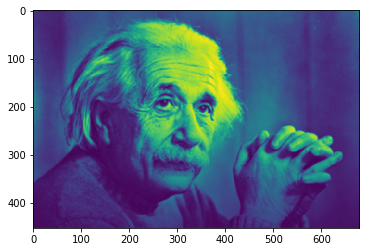


Filtro Corrente: 
 [[[ 1.000000e+00 -3.906250e-03  4.000000e+00]
  [ 4.000000e+00 -1.562500e-02  4.000000e+00]
  [ 6.000000e+00 -2.343750e-02  4.000000e+00]
  [ 4.000000e+00 -1.562500e-02  4.000000e+00]
  [ 1.000000e+00 -3.906250e-03  4.000000e+00]]

 [[ 4.000000e+00 -1.562500e-02  4.000000e+00]
  [ 1.600000e+01 -6.250000e-02  4.000000e+00]
  [ 2.400000e+01 -9.375000e-02  4.000000e+00]
  [ 1.600000e+01 -6.250000e-02  4.000000e+00]
  [ 4.000000e+00 -1.562500e-02  4.000000e+00]]

 [[ 6.000000e+00 -2.343750e-02  4.000000e+00]
  [ 2.400000e+01 -9.375000e-02  4.000000e+00]
  [-4.760000e+02  1.859375e+00  4.000000e+00]
  [ 2.400000e+01 -9.375000e-02  4.000000e+00]
  [ 6.000000e+00 -2.343750e-02  4.000000e+00]]

 [[ 4.000000e+00 -1.562500e-02  4.000000e+00]
  [ 1.600000e+01 -6.250000e-02  4.000000e+00]
  [ 2.400000e+01 -9.375000e-02  4.000000e+00]
  [ 1.600000e+01 -6.250000e-02  4.000000e+00]
  [ 4.000000e+00 -1.562500e-02  4.000000e+00]]

 [[ 1.000000e+00 -3.906250e-03  4.000000e+00]
  [ 4.

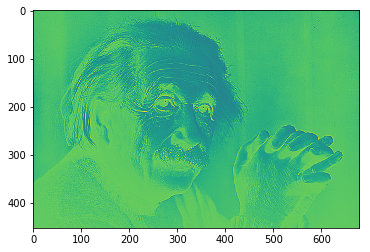



Formato do fmap: 
 (453, 680, 2)


		Feature Map em valor ABS com preto = zero : 


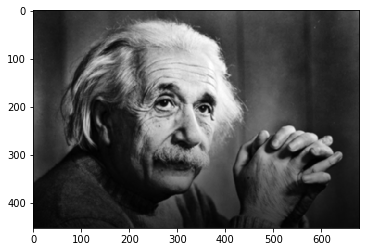

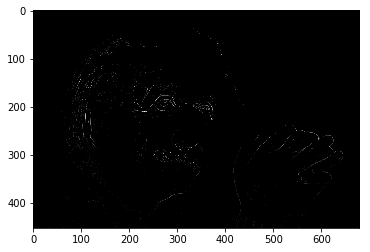



		Feature Map com mínimo = preto : 


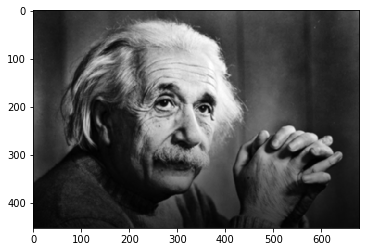

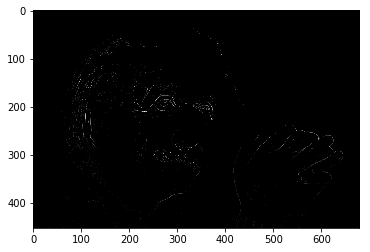

In [19]:
main()